In [1]:
## Exercise 3 | Part 1: One-vsall

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
## Setup the parameters you will use for this part of the exercise
input_layer_size = 400  # 20x20 Input Images of Digit
num_labels = 10         # 10 labels, from 1 to 10
                        # (note that we have mapped "0" to label 10)

In [3]:
## Part 1: Loading and Visualizing Data

def displayData(X, width=None):    
    if X.ndim == 1:
        X = X.reshape(1, -1)
        
    # Set width automatically if not passed in
    if not width:
        width = round(X.shape[1]**0.5)
        
    # Gray Image
    plt.set_cmap('gray')
    
    # Compute rows, cols
    m, n = X.shape
    height = int(n / width)
    
    # Compute number of items to display
    disp_rows = int(m**0.5)
    disp_cols = int(np.ceil(m / disp_rows))
    
    # Between images padding
    pad = 1
    
    # Setup blank display
    disp_arr = -np.ones((pad + disp_rows * (height + pad), 
                         pad + disp_cols * (width + pad)))
    
    # Copy each example into a patch on the display array
    curr_ex = 0
    for j in range(disp_rows):
        for i in range(disp_cols):
            if curr_ex > (m - 1):
                break
            # Copy the patch
            
            # Get the max value of the patch
            max_val = max(abs(X[curr_ex]))
            
            r = pad + j * (height + pad)
            c = pad + i * (width + pad)
            
            disp_arr[r:r+height, c:c+width] = X[curr_ex].reshape(
                height, width, order='F') / max_val
            
            curr_ex += 1
        if curr_ex > (m - 1):
            break
    
    # Display Image
    h = plt.imshow(disp_arr)
    
    # Do not show axis
    plt.axis('off')
    
    return h, disp_arr

Loading and Visualizing Data ...


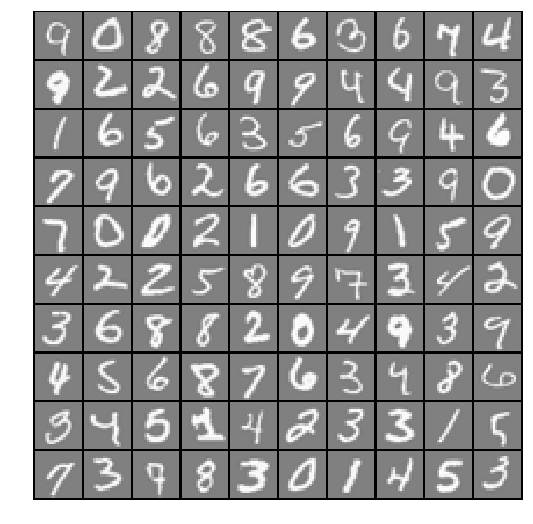

In [4]:
# Load Training Data
print('Loading and Visualizing Data ...')

# training data stored in arrays X, y
data = loadmat('../ex3/ex3data1.mat')
X = data['X']
y = data['y'].ravel()
m = len(X)

# Randomly select 100 data points to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100]]

plt.figure(figsize=(9, 9))
displayData(sel)
None

In [5]:
## Part 2a: Vectorize Logistic Regression

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g


def lrCostFunction(theta, X, y, lambda_):
    if X.ndim == 1:
        X = X.reshape(1, -1)
    
    if y.dtype == bool:
        y = y.astype(int)
        
    m = len(y)
    
    z = X.dot(theta)
    h = sigmoid(z)
    
    theta_ = np.r_[0, theta[1:]]
    
    J = (-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) / m
    J += lambda_ * sum(theta_**2) / (2 * m)
    
    grad = (h - y).dot(X) / m
    grad += lambda_ * theta_ / m
    
    return J, grad

In [6]:
# Test case for lrCostFunction
print('\nTesting lrCostFunction() with regularization')

theta_t = np.array([-2, -1, 1, 2])
X_t = np.c_[np.ones(5), np.arange(1, 16).reshape(5, 3, order='F') / 10]
y_t = np.array([1, 0, 1, 0, 1]) >= 0.5
lambda_t = 3
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

np.set_printoptions(precision=6)
print('\nCost: {:f}'.format(J))
print('Expected cost: 2.534819')
print('Gradients:')
print(' {} '.format(grad))
print('Expected gradients:')
print(' [ 0.146561 -0.548558  0.724722  1.398003]')


Testing lrCostFunction() with regularization

Cost: 2.534819
Expected cost: 2.534819
Gradients:
 [ 0.146561 -0.548558  0.724722  1.398003] 
Expected gradients:
 [ 0.146561 -0.548558  0.724722  1.398003]


In [7]:
## Part 2b: One-vs-All Training

def oneVsAll(X, y, num_labels, lambda_):
    if X.ndim == 1:
        X = X.reshape(1, -1)

    m, n = X.shape
    
    all_theta = np.zeros((num_labels, n + 1))
    
    # Add ones to the X data matrix
    X = np.c_[np.ones(m), X]
    
    # Set Initial theta
    initial_theta = np.zeros(n + 1)
    
    # Set options for minimize
    optimset = {'disp': True, 'maxiter': 500}
    
    for c in range(num_labels):
        # Run minimize to obtain the optimal theta
        result = minimize(
            lambda t: lrCostFunction(t, X, y==(c+1), lambda_), 
            initial_theta, 
            method='CG', jac=True, 
            options=optimset)
        theta = result['x']
        
        all_theta[c] = theta

    return all_theta

In [8]:
print('\nTraining One-vs-All Logistic Regression...')

lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)


Training One-vs-All Logistic Regression...
Optimization terminated successfully.
         Current function value: 0.013116
         Iterations: 129
         Function evaluations: 500
         Gradient evaluations: 500
Optimization terminated successfully.
         Current function value: 0.050810
         Iterations: 247
         Function evaluations: 742
         Gradient evaluations: 742
Optimization terminated successfully.
         Current function value: 0.057612
         Iterations: 262
         Function evaluations: 769
         Gradient evaluations: 769
Optimization terminated successfully.
         Current function value: 0.033070
         Iterations: 176
         Function evaluations: 583
         Gradient evaluations: 583
Optimization terminated successfully.
         Current function value: 0.054475
         Iterations: 216
         Function evaluations: 636
         Gradient evaluations: 636
Optimization terminated successfully.
         Current function value: 0.018266
 

In [9]:
## Part 3: Predict for One-Vs-All

def predictOneVsAll(all_theta, X):
    if X.ndim == 1:
        X = X.reshape(1, -1)

    m = len(X)                   # (m)
    num_labels = len(all_theta)  # (10)
    
    # Add ones to the X data matrix
    X = np.c_[np.ones(m), X]     # (m, 401)
    
    z = X.dot(all_theta.T)       # (m, 10)
    h = sigmoid(z)
    
    p = np.argmax(h, axis=1)     # (m,)
    
    if m == 1:
        p = p.squeeze()
    
    return p + 1

In [10]:
pred = predictOneVsAll(all_theta, X)

print('\nTraining Set Accuracy: {:.1f}'.format(np.mean(pred == y) * 100))


Training Set Accuracy: 96.4
